This script generates plots for sub-annual (seasonal) metrics, and box plot comparisons.
* Main MS Figure 5 - Seasonal profiles
* Extended Data Figure 6 - regional trends in seasonal metrics
* Main MS Figure 4 - boxplots for annual and seasonal metrics

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import seaborn as sns
from statannotations.Annotator import Annotator
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

# year used to split dataset  (< & >= split_yr)
split_yr = 2001

In [3]:
df = pd.read_csv(str(dir_base / 'GFED_8day_cp_counts_calendaryr_mean_SMA_3_season_10_90.csv'))
df_profiles = pd.read_csv(str(dir_base / 'GFED_8day_cp_average_profile_mean_SMA_3_season_10_90.csv'))

df = df.loc[df.gfed_name != 'Mask']
df_profiles = df_profiles.loc[df_profiles.gfed_name != 'Mask']

### 1) plot the GFED region seasonal profiles
* used for Figure 5

In [4]:
prepost_list = [f'pre{split_yr}', f'post{split_yr}']
prepost_list_lab = [f'1986-{split_yr-1}', f'{split_yr}-2016']
color_list = ['#001aff', '#c20202'] #red blue

In [5]:
print(df.shape)
df = df.merge(df_profiles[['gfed','gfed_name','comp_period','period_rank']], 
              how='left', 
              on=['gfed','gfed_name','comp_period'])

# increment period rank so doesnt start with zero
df[['period_rank']] = df[['period_rank']] + 1

df.loc[df.gfed_name=='SEAS', 'gfed_name'] = 'SOAS'
print(df.shape)

(15870, 7)
(15870, 8)


In [6]:
df['prepost'] = ''
df.loc[df['year'] < split_yr, 'prepost'] = f'pre{split_yr}'
df.loc[df['year'] >= split_yr, 'prepost'] = f'post{split_yr}'
df.head()

,sat_yr,sat,year,comp_period,gfed,gfed_name,count,period_rank,prepost
0,NF1986,NF,1986,1,1,BONA,0.0,43,pre2001
1,NF1986,NF,1986,1,2,TENA,2.0,4,pre2001
2,NF1986,NF,1986,1,3,CEAM,3.0,15,pre2001
3,NF1986,NF,1986,1,4,NHSA,3.0,26,pre2001
4,NF1986,NF,1986,1,5,SHSA,11.0,38,pre2001


In [7]:
#average & SDev by prepost2000
df2 = df.groupby(['gfed', 'gfed_name', 'comp_period', 'prepost'])['count']\
 .agg(['count', 'mean', 'std'])\
 .reset_index()\
 .sort_values(['gfed_name', 'comp_period', 'prepost'], ascending=True)

#calc conf int
df2['ci95'] = 1.96 * df2['std'].values / np.sqrt(df2['count'].values)

# add a smoother

# Averages for CPs of 8 days are actually quite spikey; create a simple moving average with window of 3 cps.
# to avoid NaNs in final smooth output caused by window edges, as data are circular, modify the profiles slightly 
# by adding a comp period 0 and period max(cp)+1 based on cp 1 & max(cp)
upper_cp = np.max(df2['comp_period'])
extra = df2.loc[(df2['comp_period'] == 1) | 
                (df2['comp_period'] == upper_cp)]\
           .sort_values(['gfed', 'comp_period'], ascending=[True, True])
extra.loc[extra['comp_period'] == 1, 'comp_period'] = upper_cp + 1
extra.loc[extra['comp_period'] == upper_cp, 'comp_period'] = 0

df2 = pd.concat([df2, extra])\
                .sort_values(['gfed', 'prepost', 'comp_period'], ascending=[True, True, True]).reset_index(drop=True)

# =====================================
# ATTENTION!! smoothing step below should really be applied with groupby (gfed region & decade), as it currently smooths
# ends of each region into the next. This is not currently a problem because of cp=0 & cp=max(cp)+1 combined with a
# window = 3 (i.e. the 'bad' smoothed values are artificial CPs that get dropped)
# if any of these factors change, smoothing should be applied using a groupby!
# =====================================

df2['mean_smooth3'] = df2['mean'].rolling(window=3,
                                          min_periods=None,
                                          center=True,
                                          win_type=None,
                                          on=None, axis=0,
                                          closed=None).mean()
df2['std_smooth3'] = df2['std'].rolling(window=3,
                                        min_periods=None,
                                        center=True,
                                        win_type=None,
                                        on=None, axis=0,
                                        closed=None).mean()
df2['ci95_smooth3'] = df2['ci95'].rolling(window=3,
                                        min_periods=None,
                                        center=True,
                                        win_type=None,
                                        on=None, axis=0,
                                        closed=None).mean()

# now remove the 'extra' cps; drop cp=0 & cp=max(cp)+1
df2 = df2[(df2['comp_period'] > 0) &
          (df2['comp_period'] < upper_cp + 1)]

df2.head(3)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\896429817.py:32: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df2['mean_smooth3'] = df2['mean'].rolling(window=3,
C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\896429817.py:38: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df2['std_smooth3'] = df2['std'].rolling(window=3,
C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\896429817.py:44: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df2['ci95_smooth3'] = df2['ci95'].rolling(window=3,


,gfed,gfed_name,comp_period,prepost,count,mean,std,ci95,mean_smooth3,std_smooth3,ci95_smooth3
1,1,BONA,1,post2001,16,0.0625,0.250000,0.122500,0.041667,0.166667,0.081667
2,1,BONA,2,post2001,16,0.0625,0.250000,0.122500,0.083333,0.280522,0.137456
3,1,BONA,3,post2001,16,0.1250,0.341565,0.167367,0.083333,0.280522,0.137456


plot profiles for all regions **[this plot is not currently used in the MS]**

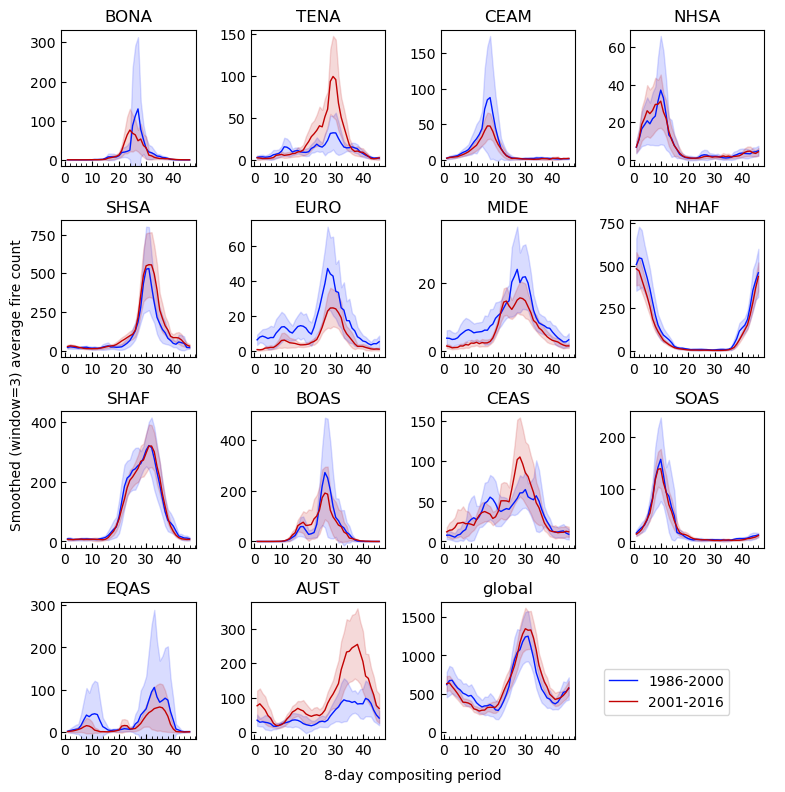

In [8]:
fig, axes = plt.subplots(figsize=(8.27, 8.27), nrows=4, ncols=4,
                         squeeze=False, sharex=False)
axes = axes.flatten()
# with pd.plotting.plot_params.use('x_compat', True):
for i, region in enumerate(np.unique(df2['gfed'])):
    ax = axes[i]
    sub = df2.loc[df2['gfed'] == region]
    max_y = np.max(sub['mean_smooth3']) * 1.1
    
    for j in range(0,2):
        sub2 = sub.loc[sub['prepost'] == prepost_list[j]]
        #max_val = np.max(sub2['mean_smooth3'])
        
        x = sub2['comp_period'].values
        y = sub2['mean_smooth3'].values
        err = sub2['ci95_smooth3'].values
        
        ax.plot(x, 
                y, 
                linestyle='-',
                linewidth=1,
                color=color_list[j],
                alpha=1,
                #legend=False,
                label='{0}'.format(prepost_list_lab[j]))
        
        #conf interval
        ax.fill_between(x, y-err, y+err,
                       alpha=0.15, edgecolor=color_list[j], facecolor=color_list[j])
        
    region_name = np.unique(sub['gfed_name'])[0]
    ax.set_title(region_name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    tick_spacing = 10
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which="major", axis="x", direction="in")
    ax.tick_params(which="minor", axis="x", direction="in")
    ax.tick_params(which="major", axis="y", direction="in")
    ax.set_ylim([-ax.get_ylim()[1]*0.05, ax.get_ylim()[1]])
    
#fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
# broad axis labels on dummy ax
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("8-day compositing period")
plt.ylabel("Smoothed (window=3) average fire count")
# make universal leg
handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.85, 0.15])
fig.tight_layout()

Create figure 5; just the most interesting regions

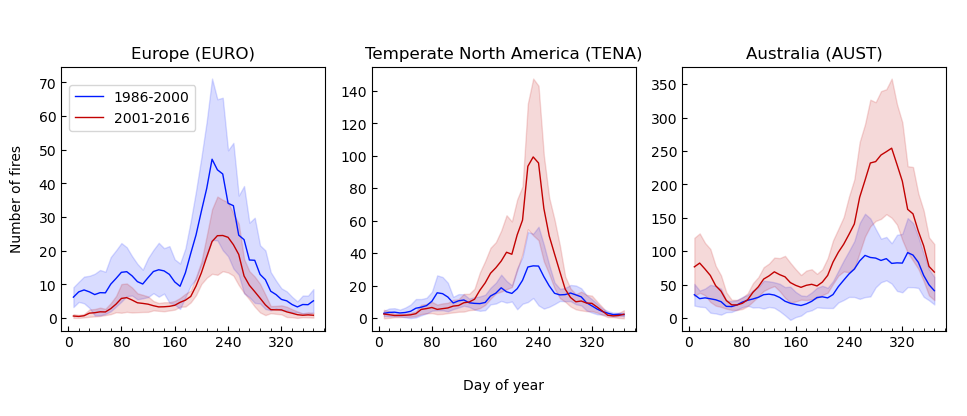

In [9]:
fig, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=3,
                         squeeze=False, sharex=False)
axes = axes.flatten()

list_labels=['Europe (EURO)','Temperate North America (TENA)','Australia (AUST)']

# with pd.plotting.plot_params.use('x_compat', True):
for i, region in enumerate(['EURO', 'TENA', 'AUST']):
    ax = axes[i]
    sub = df2.loc[df2['gfed_name'] == region]
    max_y = np.max(sub['mean_smooth3']) * 1.1
    
    for j in range(0,2):
        sub2 = sub.loc[sub['prepost'] == prepost_list[j]]
        #max_val = np.max(sub2['mean_smooth3'])
        
        x = sub2['comp_period'].values
        y = sub2['mean_smooth3'].values
        err = sub2['ci95_smooth3'].values
        
        ax.plot(x, 
                y, 
                linestyle='-',
                linewidth=1,
                color=color_list[j],
                alpha=1,
                #legend=False,
                label='{0}'.format(prepost_list_lab[j]))
        
        #conf interval?
        ax.fill_between(x, y-err, y+err,
                       alpha=0.15, edgecolor=color_list[j], facecolor=color_list[j])
        
    region_name = np.unique(sub['gfed_name'])[0]
    region_name = list_labels[i]
    ax.set_title(region_name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    tick_spacing = 10
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    # convert the compositing period axis labels to DoY
    #ax.get_xticklabels()[0]
    ax.set_xticks([0.,  10.,  20.,  30.,  40.])
    xticks = ax.get_xticks()
    ax.set_xticklabels([int(x * 8) for x in xticks])
    
    ax.tick_params(which="major", axis="x", direction="in")
    ax.tick_params(which="minor", axis="x", direction="in")
    ax.tick_params(which="major", axis="y", direction="in")
    ax.set_ylim([-ax.get_ylim()[1]*0.05, ax.get_ylim()[1]])
    # make plots square
    ratio = 1.0
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)     
#fig.delaxes(axes[-2])
#fig.delaxes(axes[-1])
# broad axis labels on dummy ax
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Day of year", labelpad=-20)
plt.ylabel("Number of fires")
# make universal leg
handles, labels = ax.get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.85, 0.15])
leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.16, 0.73])
fig.tight_layout()
fig.savefig(str(dir_out_figures / f'05_seasonal_profiles.png'), dpi=800)

### 2) Trend in subannual metrics 
* Figure S6 in extended data
* reuses some code from the ANF/climate timeseries plotting 

In [10]:
#params for figure plotting
mm = 1/25.4
av_color_list = ['#fec44f','#ec7014','#cc4c02'] #oranges  #fe9929
eq_list = ['$\leq$', ' > ']

In [11]:
# calculate peak fire activity magnitude
peak_value = df.groupby(['year','gfed','gfed_name'])['count'].max().reset_index()
peak_value=peak_value[['year','gfed','gfed_name','count']].rename(columns={'count': 'value'})
peak_value.head(3)

,year,gfed,gfed_name,value
0,1986,1,BONA,28.0
1,1986,2,TENA,81.0
2,1986,3,CEAM,93.0


In [12]:
# determine season length simply as sum of CPs exceeding 
# the mean or median CP fire count per calendar year
df_stats=df.groupby(['gfed','gfed_name'])['count'].agg(['mean', 'median']).reset_index()
df2=df.merge(df_stats, how='left', on=['gfed','gfed_name'])

df2['fs_mean'] = 0
df2.loc[df2['count'] > df2['mean'], 'fs_mean'] = 1
df2['fs_median'] = 0
df2.loc[df2['count'] > df2['median'], 'fs_median'] = 1
season_length = df2.groupby(['year','gfed','gfed_name'])[['fs_mean','fs_median']].sum().reset_index()

# edit: just using mean for now
season_length = season_length[['year','gfed','gfed_name','fs_mean']].rename(columns={'fs_mean': 'value'})

# currently season length is number of CPs, convert to number of days (1CP is 8 days long)
season_length['value'] = season_length['value'] * 8

season_length.head()

,year,gfed,gfed_name,value
0,1986,1,BONA,48
1,1986,2,TENA,56
2,1986,3,CEAM,104
3,1986,4,NHSA,80
4,1986,5,SHSA,72


### identify change points
save the season length and pfam data to disk, and then run the 'change_point_identification.r' R script to determine where trends change over time

In [13]:
season_length.to_csv(str(dir_base / 'GFED_fire_season_length.csv'), index=False)
peak_value.to_csv(str(dir_base / 'GFED_peak_fire_activity_magnitude.csv'), index=False)

### do peak fire activity magnitude plotting

In [14]:
# make more readable
peak_value['gfed_full_name'] = ''
peak_value.loc[peak_value.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
peak_value.loc[peak_value.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
peak_value.loc[peak_value.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
peak_value.loc[peak_value.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
peak_value.loc[peak_value.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
peak_value.loc[peak_value.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
peak_value.loc[peak_value.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
peak_value.loc[peak_value.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
peak_value.loc[peak_value.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
peak_value.loc[peak_value.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
peak_value.loc[peak_value.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
peak_value.loc[peak_value.gfed_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
peak_value.loc[peak_value.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
peak_value.loc[peak_value.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
peak_value.loc[peak_value.gfed_name=='global', 'gfed_full_name'] = 'Global'

peak_value.head()
peak_value.gfed_full_name.unique()

array(['Boreal North America (BONA)', 'Temperate North America (TENA)',
       'Central America (CEAM)',
       'Northern Hemisphere South America (NHSA)',
       'Southern Hemisphere South America (SHSA)', 'Europe (EURO)',
       'Middle East (MIDE)', 'Northern Hemisphere Africa (NHAF)',
       'Southern Hemisphere Africa (SHAF)', 'Boreal Asia (BOAS)',
       'Central Asia (CEAS)', 'Southern Asia (SOAS)',
       'Equatorial Asia (EQAS)', 'Australasia (AUST)', 'Global'],
      dtype=object)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\2198172435.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


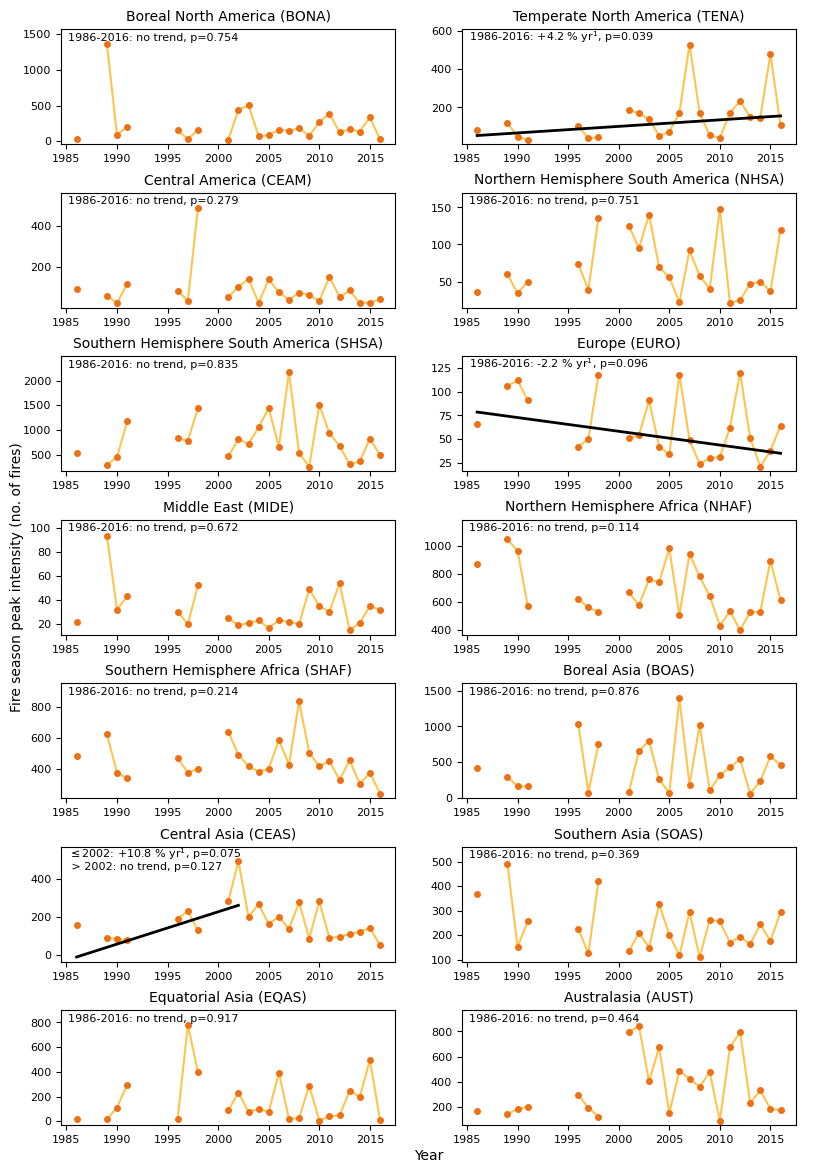

In [15]:
# peak intensity aka 'peak fire activity magnitude' (PFAM).
# values in region_dict are change point years, identified using 'change_points.r'
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [None, None], 
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None], 
               'SHAF':  [None, None], 
               'BOAS':  [None, None],
               'CEAS':  [2002, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None], 
               #'global':[2007, None]
              }

#fig, axes = plt.subplots(figsize=(12, 16), nrows=7, ncols=2,
#                       squeeze=False, sharex=False,
#                       gridspec_kw=dict(hspace=0.3, wspace=0.3))
fig, axes = plt.subplots(figsize=(210*mm,297*mm), nrows=7, ncols=2,
                       squeeze=False, sharex=False,
                       gridspec_kw=dict(hspace=0.42, wspace=0.2))

axes=axes.flatten()


statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })

for i, (key, values) in enumerate(region_dict.items()):
    #print(i, key, values)
    
    ax1 = axes[i]
    
    d = peak_value.loc[peak_value.gfed_name==key].copy()
     
    x = d['year'].values    
    y = d['value'].values
    # for calculating slope %
    y86 = d.loc[d.year==1986, 'value'].values
    if y86 < 1:
        y86 = 1
    yn = y / y86
    
    # first store the 1986-2016 stats for completeness       
    tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
    tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)

    statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                     round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                     round(slope_n,6), round(lower_n,6), round(upper_n,6)]    
    
    #ax1.plot(x, y, marker='', ms=4, linestyle='-', color=av_color_list[0], alpha=0.4, zorder=1) 
    #ax1.plot(x, y, marker='o', ms=4, linestyle='none', color=av_color_list[1], alpha=0.6, zorder=2) #3690c0
    
    #AVHRR (oranges)
    #ax1.plot(x2, y2, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
    ax1.plot(x, y, marker='o', ms=4, linestyle='none', color=av_color_list[1], alpha=1, zorder=2) #3690c0
    # only add lines to continuous points.
    #Trying to do this programmatically is difficult (even without d_av.dropna) in this case because in the avhrr
    #timeseries index=0 is a non-nan value, but index=1 is a Nan. This apparently can make mpl fail silently.
    #solution is a crude brute force approach because we know where the NaNs should be each time!
    # 1989,90,91
    x_ix = (x > 1988) & (x < 1992)
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1)
    # 1996,97,98
    x_ix = (x > 1995) & (x < 1999)
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1)
    #lines after 2000
    x_ix = x > 2000
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
    
    if values[0]: #i.e. have a change point
        # now do subdivided analysis        
        a = d.loc[d.year <= values[0]]
        b = d.loc[d.year >  values[0]]
        #b = d_av.loc[d_av.year >=  values[0]]    # arguably could add the CP year to both series?    
        for k, dd in enumerate([a,b]):
            x = dd['year'].values        
            y = dd['value'].values
            yn = y / y86
            txt_offset = k * 0.1
            # calc stats
            tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
            tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)            
            
            if p <= 0.1:
                ax1.plot(x, x * slope + intercept, color='k', linewidth=2, linestyle='-', zorder=3)
                label=r'{}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[0], slope_n * 100, p_n) 
                plt.text(0.02, 0.9 - txt_offset, label, color='k', fontsize=8, transform = ax1.transAxes)
            else:
                label=r'{}{}: no trend, p={:.3f}'.format(eq_list[k], values[0], p_n) 
                plt.text(0.02, 0.9 - txt_offset, label, color='k', fontsize=8, transform = ax1.transAxes)        
            
            # collate stats
            statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                             round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                             round(slope_n,6), round(lower_n,6), round(upper_n,6)]
            #print(d.gfed_full_name.values[0], p,p_n,slope_n)
    else: #i.e. no change point
        if p <= 0.10:
            ax1.plot(x, x * slope + intercept, color='k', linewidth=2, linestyle='-', zorder=3)
            label=r'1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(slope_n * 100, p_n) 
            plt.text(0.02, 0.9, label, color='k', fontsize=8, transform = ax1.transAxes)
        else:
            # ax1.plot(x, x * slope + intercept, color_list[0], linewidth=1, linestyle='-')
            label=r'1986-2016: no trend, p={:.3f}'.format(p_n) 
            plt.text(0.02, 0.9, label, color='k', fontsize=8, transform = ax1.transAxes)               
        #print(d.gfed_full_name.values[0], p,p_n,slope_n)
    
    ax1.set_title(d.gfed_full_name.values[0], fontsize=10)
    
    # expand upper y limits for text
    ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
    ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='minor', labelsize=8)
    
# broad axis labels on dummy ax
fig.add_subplot(111, frameon=False)
ax1 = plt.gca()
ax1.set_xlabel("Year", color='k', fontsize=10, labelpad=-0)
ax1.set_ylabel("Fire season peak intensity (no. of fires)", fontsize=10)
plt.box(False)
ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.tight_layout()

fig.savefig(str(dir_out_figures / 's6_timeseries_peak_value.png'), dpi=1000)
fig.savefig(str(dir_out_figures / 's6_timeseries_peak_value.pdf'))
#statstable
statstable.to_csv(str(dir_out_figures / 's6_timeseries_peak_value.csv'), index=False)

do season length plotting

In [16]:
# make more readable
season_length['gfed_full_name'] = ''
season_length.loc[season_length.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
season_length.loc[season_length.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
season_length.loc[season_length.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
season_length.loc[season_length.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
season_length.loc[season_length.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
season_length.loc[season_length.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
season_length.loc[season_length.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
season_length.loc[season_length.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
season_length.loc[season_length.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
season_length.loc[season_length.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
season_length.loc[season_length.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
season_length.loc[season_length.gfed_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
season_length.loc[season_length.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
season_length.loc[season_length.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
season_length.loc[season_length.gfed_name=='global', 'gfed_full_name'] = 'Global'

season_length.head()
season_length.gfed_full_name.unique()

array(['Boreal North America (BONA)', 'Temperate North America (TENA)',
       'Central America (CEAM)',
       'Northern Hemisphere South America (NHSA)',
       'Southern Hemisphere South America (SHSA)', 'Europe (EURO)',
       'Middle East (MIDE)', 'Northern Hemisphere Africa (NHAF)',
       'Southern Hemisphere Africa (SHAF)', 'Boreal Asia (BOAS)',
       'Central Asia (CEAS)', 'Southern Asia (SOAS)',
       'Equatorial Asia (EQAS)', 'Australasia (AUST)', 'Global'],
      dtype=object)

### do seasonality plotting

C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\3746444296.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


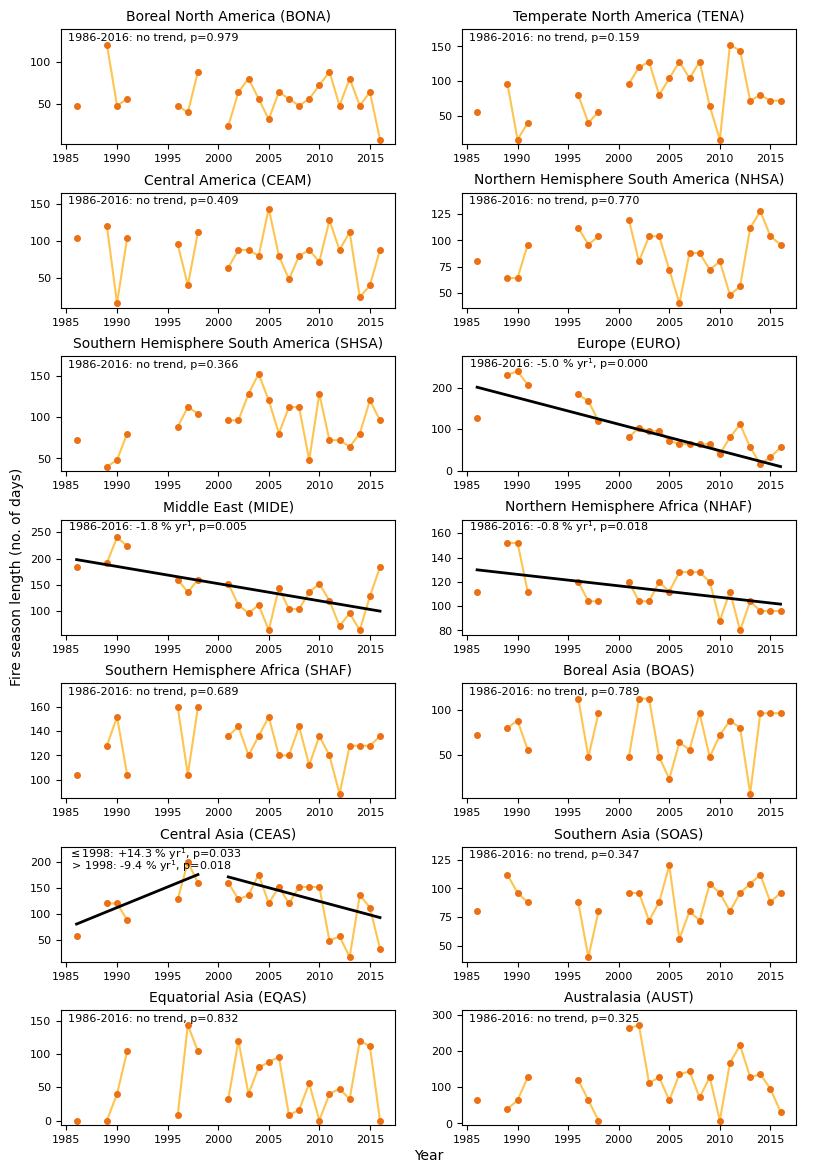

In [17]:
# seasonality
# values in region_dict are change point years, identified using 'change_points.r'
region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [None, None], 
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None], 
               'SHAF':  [None, None], 
               'BOAS':  [None, None],
               'CEAS':  [1998, None], 
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }


fig, axes = plt.subplots(figsize=(210*mm,297*mm), nrows=7, ncols=2,
                       squeeze=False, sharex=False,
                       gridspec_kw=dict(hspace=0.42, wspace=0.2))

axes=axes.flatten()


statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })

for i, (key, values) in enumerate(region_dict.items()):
    #print(i, key, values)
    
    ax1 = axes[i]
    
    d = season_length.loc[season_length.gfed_name==key].copy()
     
    x = d['year'].values    
    y = d['value'].values
    # for calculating slope %
    y86 = d.loc[d.year==1986, 'value'].values
    if y86 < 1:
        y86 = 1
    yn = y / y86
    
    # first store the 1986-2016 stats for completeness       
    tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
    tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)

    statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                     round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                     round(slope_n,6), round(lower_n,6), round(upper_n,6)]    
    
    #ax1.plot(x, y, marker='', ms=4, linestyle='-', color=av_color_list[0], alpha=0.4, zorder=1) 
    #ax1.plot(x, y, marker='o', ms=4, linestyle='none', color=av_color_list[1], alpha=0.6, zorder=2) #3690c0

    #AVHRR (oranges)
    #ax1.plot(x2, y2, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
    ax1.plot(x, y, marker='o', ms=4, linestyle='none', color=av_color_list[1], alpha=1, zorder=2) #3690c0
    # only add lines to continuous points.
    #Trying to do this programmatically is difficult (even without d_av.dropna) in this case because in the avhrr
    #timeseries index=0 is a non-nan value, but index=1 is a Nan. This apparently can make mpl fail silently.
    #solution is a crude brute force approach because we know where the NaNs should be each time!
    # 1989,90,91
    x_ix = (x > 1988) & (x < 1992)
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1)
    # 1996,97,98
    x_ix = (x > 1995) & (x < 1999)
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1)
    #lines after 2000
    x_ix = x > 2000
    x2 = x[x_ix]
    y2 = y[x_ix]
    ax1.plot(x2, y2, marker='', ms=4, 
             linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 

    
    # AVHRR ============
    if values[0]: #i.e. have a change point
        # now do subdivided analysis        
        a = d.loc[d.year <= values[0]]
        b = d.loc[d.year >  values[0]]
        #b = d_av.loc[d_av.year >=  values[0]]    # arguably could add the CP year to both series?    
        for k, dd in enumerate([a,b]):
            x = dd['year'].values        
            y = dd['value'].values
            yn = y / y86
            txt_offset = k * 0.1
            # calc stats
            tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)
            tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, yn)            
            
            if p <= 0.1:
                ax1.plot(x, x * slope + intercept, color='k', linewidth=2, linestyle='-', zorder=3)
                label=r'{}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(eq_list[k], values[0], slope_n * 100, p_n) 
                plt.text(0.02, 0.9 - txt_offset, label, color='k', fontsize=8, transform = ax1.transAxes)
            else:
                label=r'{}{}: no trend, p={:.3f}'.format(eq_list[k], values[0], p_n) 
                plt.text(0.02, 0.9 - txt_offset, label, color='k', fontsize=8, transform = ax1.transAxes)        
            
            # collate stats
            statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                             round(tau_n,6), round(p_n,6), round(intercept_n,6), 
                             round(slope_n,6), round(lower_n,6), round(upper_n,6)]
    
    else: #i.e. no change point
        if p <= 0.10:
            ax1.plot(x, x * slope + intercept, color='k', linewidth=2, linestyle='-', zorder=3)
            label=r'1986-2016: {:+.1f} % yr$^1$, p={:.3f}'.format(slope_n * 100, p_n) 
            plt.text(0.02, 0.9, label, color='k', fontsize=8, transform = ax1.transAxes)
        else:
            # ax1.plot(x, x * slope + intercept, color_list[0], linewidth=1, linestyle='-')
            label=r'1986-2016: no trend, p={:.3f}'.format(p_n) 
            plt.text(0.02, 0.9, label, color='k', fontsize=8, transform = ax1.transAxes)               
       
    ax1.set_title(d.gfed_full_name.values[0], fontsize=10)
    
    # expand upper y limits for text
    ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
    ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='minor', labelsize=8)
    
# broad axis labels on dummy ax
fig.add_subplot(111, frameon=False)
ax1 = plt.gca()
ax1.set_xlabel("Year", color='k', fontsize=10, labelpad=-0)
ax1.set_ylabel("Fire season length (no. of days)", fontsize=10)
plt.box(False)
ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.tight_layout()

fig.savefig(str(dir_out_figures / 's6_timeseries_season_length.png'), dpi=1000)
fig.savefig(str(dir_out_figures / 's6_timeseries_season_length.pdf'))
# #statstable
statstable.to_csv(str(dir_out_figures / 's6_timeseries_season_length.csv'),index=False)

# 3) Boxplots

in addition to season_length and peak value dfs, also need to load GFED ANF, VPD and FWSL

In [18]:
fp_anf = str(dir_base / 'GFED_annual_counts_calendaryr.csv')
fp_vpd = str(dir_base / 'avhrr_and_vpd_fulljoin_1986-2016.csv') #gfed_region_mean_vpd.csv
# for FWSL cannot use gfed_region_mean_fwsl.csv; contains individual ensemble members before aggregation
fp_fwsl = str(dir_base / 'avhrr_and_fire_weather_fulljoin_1986-2016.csv')  

In [19]:
df_anf = pd.read_csv(fp_anf)
df_vpd = pd.read_csv(fp_vpd)
df_fwsl = pd.read_csv(fp_fwsl)

In [20]:
df_vpd

,gfed_name,gfed,year,vpd_mean,n_mean,sat_yr,sat,count,ncount
0,BONA,1,1986,0.523740,1.000000,NF1986,NF,228.0,1.000000
1,TENA,2,1986,1.404542,1.000000,NF1986,NF,588.0,1.000000
2,CEAM,3,1986,1.915578,1.000000,NF1986,NF,637.0,1.000000
3,NHSA,4,1986,1.453079,1.000000,NF1986,NF,275.0,1.000000
4,SHSA,5,1986,1.540240,1.000000,NF1986,NF,3179.0,1.000000
...,...,...,...,...,...,...,...,...,...
460,CEAS,11,2016,1.019937,1.054541,NP2016,NP,587.0,0.503431
461,SOAS,12,2016,2.298264,1.019221,NP2016,NP,1648.0,1.066667
462,EQAS,13,2016,1.335668,1.077404,NP2016,NP,100.0,0.606061
463,AUST,14,2016,2.939493,0.981708,NP2016,NP,1458.0,0.713307


do preprocessing and reformatting of the various dataframes to align with plotting

In [21]:
#   ANF 
df_anf = df_anf[['year','gfed','gfed_name','count']]
df_anf = df_anf.loc[(df_anf.gfed > 0)] #filter mask
df_anf['era'] = np.nan
df_anf.loc[df_anf['year'] < split_yr, 'era'] = 1
df_anf.loc[df_anf['year'] >= split_yr, 'era'] = 2
df_anf = df_anf.rename(columns={'count':'value'})

# FWSL
df_fwsl = df_fwsl.dropna() #removes years with no fire data
df_fwsl = pd.melt(df_fwsl, ['gfed','gfed_name','year'], ['fdi_mean'])
df_fwsl = df_fwsl.rename(columns={'variable':'var'})
df_fwsl['era'] = np.nan
df_fwsl.loc[df_fwsl['year'] < split_yr, 'era'] = 1
df_fwsl.loc[df_fwsl['year'] >= split_yr, 'era'] = 2

# VPD
df_vpd = df_vpd.dropna() #removes years with no fire data
df_vpd = pd.melt(df_vpd, ['gfed','gfed_name','year'], ['vpd_mean'])  # go long with mean
df_vpd = df_vpd.rename(columns={'variable':'var'})
df_vpd['era'] = np.nan
df_vpd.loc[df_vpd['year'] < split_yr, 'era'] = 1
df_vpd.loc[df_vpd['year'] >= split_yr, 'era'] = 2

# peak value
df_pfam = peak_value.copy()
df_pfam = df_pfam.loc[(df_pfam.gfed > 0)] #filter maskdf2['era'] = np.nan
df_pfam.loc[df_pfam['year'] < split_yr, 'era'] = 1
df_pfam.loc[df_pfam['year'] >= split_yr, 'era'] = 2

# season_length
df_length = season_length.copy()
df_length = df_length.loc[(df_length.gfed > 0)] #filter maskdf2['era'] = np.nan
df_length.loc[df_length['year'] < split_yr, 'era'] = 1
df_length.loc[df_length['year'] >= split_yr, 'era'] = 2

# for plotting purposes
df_anf['era_lab']='1986-2000'
df_vpd['era_lab']='1986-2000'
df_fwsl['era_lab']='1986-2000'
df_pfam['era_lab']='1986-2000'
df_length['era_lab']='1986-2000'

df_anf.loc[df_anf['era'] == 2, 'era_lab'] = '2001-2016'
df_vpd.loc[df_vpd['era'] == 2, 'era_lab'] = '2001-2016'
df_fwsl.loc[df_fwsl['era'] == 2, 'era_lab'] = '2001-2016'
df_pfam.loc[df_pfam['era'] == 2, 'era_lab'] = '2001-2016'
df_length.loc[df_length['era'] == 2, 'era_lab'] = '2001-2016'

make a plotting function

In [22]:
def boxplotter(df, ax, subset_list, pairs, subset_col, list_palette, ylab, do_swarm=1):
    sns.set_palette(sns.color_palette(list_palette))

    #prep df
    df = df.loc[df[subset_col].isin(subset_list)].copy()
    # this allows us to change plotting order, like a factor level in R
    df[subset_col] = pd.Categorical(df[subset_col], categories=subset_list)
    
    
    #boxplot
    ax = sns.boxplot(x=subset_col, hue="era_lab", y="value", notch=False, 
                data=df, ax=ax,
                linewidth=0.8, showfliers=False, whis=1.5, # **PROPS
               )
    # seaborn doesn't alpha; suggested changing via mpl https://github.com/mwaskom/seaborn/issues/979
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8)) 
  
    if do_swarm:
        # swarmplot
        ax = sns.swarmplot(x=subset_col, hue="era_lab", y="value",
                    data=df, ax=ax, 
                    dodge=True, size=3, edgecolor='none', color='0.2', alpha=1
                   )
    
    # annotate the box plots using statannotations
    if pairs:
        annotator = Annotator(ax, pairs=pairs, data=df, x=subset_col, y='value', hue='era_lab', order=subset_list)
        annotator.configure(
            test="Mann-Whitney",
            text_format="simple",
            show_test_name=False,
            verbose=1,
            line_width=0.8,
            fontsize=7)
        obj = annotator.apply_and_annotate()
    
    #tidy up
    handles, labels = ax.get_legend_handles_labels() # override the legend to just have two features
    leg = ax.legend(handles[0:2],labels[0:2], loc='best', 
                    #bbox_to_anchor=(0.0, .28), 
                    fontsize=7)
    #modify legend bits
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=7.5)
    ax.set(xlabel=None)
    ax.set_ylabel(ylab, fontsize=9)
    return ax

make the boxplot

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

SHAF_1986-2000 vs. SHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:5.346e-01 U_stat=6.600e+01
NHAF_1986-2000 vs. NHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:2.247e-02 U_stat=9.000e+01
EURO_1986-2000 vs. EURO_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:8.158e-06 U_stat=1.120e+02
TENA_1986-2000 vs. TENA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.836e-02 U_stat=2.100e+01
AUST_1986-2000 vs. AUST_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.199e-02 U_stat=1.900e+01
SHSA_1986-2000 vs. SHSA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:4.127e-01 U_stat=4.300e+01


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

SHAF_1986-2000 vs. SHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:8.411e-01 U_stat=5.250e+01
NHAF_1986-2000 vs. NHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:4.921e-01 U_stat=6.700e+01
EURO_1986-2000 vs. EURO_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:7.095e-02 U_stat=8.350e+01
TENA_1986-2000 vs. TENA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:6.796e-03 U_stat=1.500e+01
AUST_1986-2000 vs. AUST_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.490e-02 U_stat=2.000e+01
SHSA_1986-2000 vs. SHSA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:9.740e-01 U_stat=5.700e+01


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

SHAF_1986-2000 vs. SHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:9.194e-01 U_stat=5.800e+01
NHAF_1986-2000 vs. NHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:2.234e-01 U_stat=7.450e+01
EURO_1986-2000 vs. EURO_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.991e-04 U_stat=1.120e+02
TENA_1986-2000 vs. TENA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.186e-02 U_stat=1.800e+01
AUST_1986-2000 vs. AUST_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:3.157e-02 U_stat=2.350e+01
SHSA_1986-2000 vs. SHSA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.397e-01 U_stat=3.350e+01


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

SHAF_1986-2000 vs. SHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:2.007e-03 U_stat=1.200e+01
NHAF_1986-2000 vs. NHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:5.384e-04 U_stat=8.000e+00
EURO_1986-2000 vs. EURO_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:5.384e-04 U_stat=8.000e+00
TENA_1986-2000 vs. TENA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.477e-03 U_stat=1.100e+01
AUST_1986-2000 vs. AUST_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:3.760e-01 U_stat=4.200e+01
SHSA_1986-2000 vs. SHSA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:3.263e-05 U_stat=2.000e+00


C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

SHAF_1986-2000 vs. SHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:2.726e-02 U_stat=2.300e+01
NHAF_1986-2000 vs. NHAF_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:4.601e-03 U_stat=1.500e+01
EURO_1986-2000 vs. EURO_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:2.490e-01 U_stat=3.800e+01
TENA_1986-2000 vs. TENA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:1.550e-04 U_stat=5.000e+00
AUST_1986-2000 vs. AUST_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:7.198e-01 U_stat=5.000e+01
SHSA_1986-2000 vs. SHSA_2001-2016: Mann-Whitney-Wilcoxon test two-sided, P_val:3.532e-03 U_stat=1.400e+01


C:\Users\mdejong\AppData\Local\Temp\ipykernel_22924\900759566.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


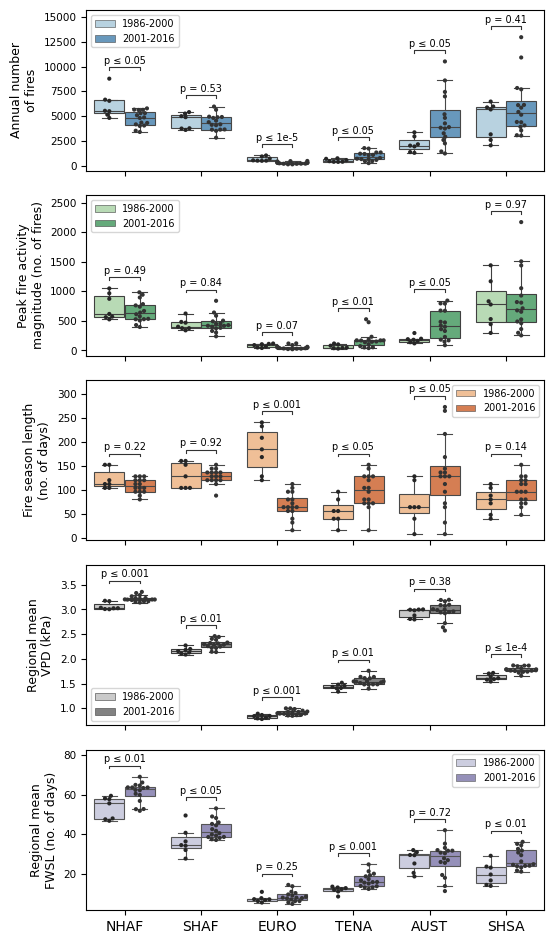

In [23]:
pairs = [(('NHAF','1986-2000'),('NHAF','2001-2016')),
        (('SHAF','1986-2000'),('SHAF','2001-2016')),
        (('EURO','1986-2000'),('EURO','2001-2016')),
        (('TENA','1986-2000'),('TENA','2001-2016')),
        (('AUST','1986-2000'),('AUST','2001-2016')),
        (('SHSA','1986-2000'),('SHSA','2001-2016')),]

color_list1 = ['#9ecae1','#3182bd'] #blues
color_list2 = ['#a1d99b','#31a354'] #greens
color_list3 = ['#fdae6b','#e6550d'] #oranges
color_list4 = ['#bdbdbd','#636363'] #greys
color_list5 = ['#bcbddc','#756bb1'] #purples

sub_region_list=['NHAF','SHAF','EURO','TENA','AUST','SHSA']


fig, axes = plt.subplots(figsize=(150*mm, 297*mm), nrows=5, ncols=1,
                         squeeze=False, sharex=True,
                         gridspec_kw=dict(hspace=0.15, wspace=0.3))
axes = axes.flatten()

boxplotter(df=df_anf, ax=axes[0], subset_list=sub_region_list, pairs=pairs, subset_col='gfed_name', 
       list_palette=color_list1, ylab='Annual number\nof fires')
boxplotter(df=df_pfam, ax=axes[1], subset_list=sub_region_list, pairs=pairs, subset_col='gfed_name', 
         list_palette=color_list2, ylab='Peak fire activity\nmagnitude (no. of fires)')
boxplotter(df=df_length, ax=axes[2], subset_list=sub_region_list, pairs=pairs, subset_col='gfed_name', 
        list_palette=color_list3, ylab='Fire season length\n(no. of days)')
boxplotter(df=df_vpd, ax=axes[3], subset_list=sub_region_list, pairs=pairs, subset_col='gfed_name', 
        list_palette=color_list4, ylab='Regional mean\nVPD (kPa)')
boxplotter(df=df_fwsl, ax=axes[4], subset_list=sub_region_list, pairs=pairs, subset_col='gfed_name', 
        list_palette=color_list5, ylab='Regional mean\nFWSL (no. of days)')

fig.tight_layout()

fig.savefig(str(dir_out_figures / '04_combined_boxplots.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / '04_combined_boxplots.pdf'))

### Summarise statistics for all variables for compiling Extended Materials Table 2
* need summary stats for all regions and variables in Figure 4 

In [24]:
#ANF
df = df_anf.copy()
df_stats = df.groupby(['gfed','gfed_name','era'])['value'].describe().reset_index()
df_stats['levene_p'] = np.nan
df_stats['mwu_2side'] = np.nan
df_stats['mwu_2side_p'] = np.nan

for i, region in enumerate(np.unique(df['gfed'])):
    if region == 99:
        continue
    sub = df.loc[df['gfed'] == region]
    #region_name = np.unique(sub['gfed_name'])[0]
    #region_full_name = np.unique(sub['gfed_full_name'])[0]
    
    ## tests
    levene = scipy.stats.levene(sub.loc[sub['era']==1,'value'].values, 
                             sub.loc[sub['era']==2,'value'].values, 
                             center='median')   
    mwu2 = scipy.stats.mannwhitneyu(sub.loc[sub['era']==1,'value'].values, 
                                   sub.loc[sub['era']==2,'value'].values,
                                   alternative='two-sided')

    df_stats.loc[df_stats.gfed==region, 'levene_p'] = levene[1]  
    df_stats.loc[df_stats.gfed==region, 'mwu_2side'] = mwu2[0]
    df_stats.loc[df_stats.gfed==region, 'mwu_2side_p'] = mwu2[1]  
df_stats_anf = df_stats.copy()

In [25]:
#PFAM
df = df_pfam.copy()
df_stats = df.groupby(['gfed','gfed_name','era'])['value'].describe().reset_index()
df_stats['levene_p'] = np.nan
df_stats['mwu_2side'] = np.nan
df_stats['mwu_2side_p'] = np.nan

for i, region in enumerate(np.unique(df['gfed'])):
    if region == 99:
        continue
    sub = df.loc[df['gfed'] == region]
    #region_name = np.unique(sub['gfed_name'])[0]
    #region_full_name = np.unique(sub['gfed_full_name'])[0]
    
    ## tests
    levene = scipy.stats.levene(sub.loc[sub['era']==1,'value'].values, 
                             sub.loc[sub['era']==2,'value'].values, 
                             center='median')   
    mwu2 = scipy.stats.mannwhitneyu(sub.loc[sub['era']==1,'value'].values, 
                                   sub.loc[sub['era']==2,'value'].values,
                                   alternative='two-sided')

    df_stats.loc[df_stats.gfed==region, 'levene_p'] = levene[1]  
    df_stats.loc[df_stats.gfed==region, 'mwu_2side'] = mwu2[0]
    df_stats.loc[df_stats.gfed==region, 'mwu_2side_p'] = mwu2[1]  
df_stats_pfam = df_stats.copy()

In [26]:
# season length
df = df_length.copy()
df_stats = df.groupby(['gfed','gfed_name','era'])['value'].describe().reset_index()
df_stats['levene_p'] = np.nan
df_stats['mwu_2side'] = np.nan
df_stats['mwu_2side_p'] = np.nan

for i, region in enumerate(np.unique(df['gfed'])):
    if region == 99:
        continue
    sub = df.loc[df['gfed'] == region]
    #region_name = np.unique(sub['gfed_name'])[0]
    #region_full_name = np.unique(sub['gfed_full_name'])[0]
    
    ## tests
    levene = scipy.stats.levene(sub.loc[sub['era']==1,'value'].values, 
                             sub.loc[sub['era']==2,'value'].values, 
                             center='median')   
    mwu2 = scipy.stats.mannwhitneyu(sub.loc[sub['era']==1,'value'].values, 
                                   sub.loc[sub['era']==2,'value'].values,
                                   alternative='two-sided')

    df_stats.loc[df_stats.gfed==region, 'levene_p'] = levene[1]  
    df_stats.loc[df_stats.gfed==region, 'mwu_2side'] = mwu2[0]
    df_stats.loc[df_stats.gfed==region, 'mwu_2side_p'] = mwu2[1]  
df_stats_length = df_stats.copy()

In [27]:
#VPD 
df = df_vpd.copy()
df_stats = df.groupby(['gfed','gfed_name','era'])['value'].describe().reset_index()
df_stats['levene_p'] = np.nan
df_stats['mwu_2side'] = np.nan
df_stats['mwu_2side_p'] = np.nan

for i, region in enumerate(np.unique(df['gfed'])):
    if region == 99:
        continue
    sub = df.loc[df['gfed'] == region]
    #region_name = np.unique(sub['gfed_name'])[0]
    #region_full_name = np.unique(sub['gfed_full_name'])[0]
    
    ## tests
    levene = scipy.stats.levene(sub.loc[sub['era']==1,'value'].values, 
                             sub.loc[sub['era']==2,'value'].values, 
                             center='median')   
    mwu2 = scipy.stats.mannwhitneyu(sub.loc[sub['era']==1,'value'].values, 
                                   sub.loc[sub['era']==2,'value'].values,
                                   alternative='two-sided')

    df_stats.loc[df_stats.gfed==region, 'levene_p'] = levene[1]  
    df_stats.loc[df_stats.gfed==region, 'mwu_2side'] = mwu2[0]
    df_stats.loc[df_stats.gfed==region, 'mwu_2side_p'] = mwu2[1]  
df_stats_vpd = df_stats.copy()

In [28]:
# FWSL
df = df_fwsl.copy()
df_stats = df.groupby(['gfed','gfed_name','era'])['value'].describe().reset_index()
df_stats['levene_p'] = np.nan
df_stats['mwu_2side'] = np.nan
df_stats['mwu_2side_p'] = np.nan

for i, region in enumerate(np.unique(df['gfed'])):
    if region == 99:
        continue
    sub = df.loc[df['gfed'] == region]
    #region_name = np.unique(sub['gfed_name'])[0]
    #region_full_name = np.unique(sub['gfed_full_name'])[0]
    
    ## tests
    levene = scipy.stats.levene(sub.loc[sub['era']==1,'value'].values, 
                             sub.loc[sub['era']==2,'value'].values, 
                             center='median')   
    mwu2 = scipy.stats.mannwhitneyu(sub.loc[sub['era']==1,'value'].values, 
                                   sub.loc[sub['era']==2,'value'].values,
                                   alternative='two-sided')

    df_stats.loc[df_stats.gfed==region, 'levene_p'] = levene[1]  
    df_stats.loc[df_stats.gfed==region, 'mwu_2side'] = mwu2[0]
    df_stats.loc[df_stats.gfed==region, 'mwu_2side_p'] = mwu2[1]  
df_stats_fwsl = df_stats.copy()

In [29]:
# save to disk
df_stats_anf.to_csv(str(dir_out_figures / '04_stats_for_table2_anf.csv'),index=False)
df_stats_pfam.to_csv(str(dir_out_figures / '04_stats_for_table2_pfam.csv'),index=False)
df_stats_length.to_csv(str(dir_out_figures / '04_stats_for_table2_season_length.csv'),index=False)
df_stats_vpd.to_csv(str(dir_out_figures / '04_stats_for_table2_vpd.csv'),index=False)
df_stats_fwsl.to_csv(str(dir_out_figures / '04_stats_for_table2_fwsl.csv'),index=False)